In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [2]:
spark_generator = NewsHeadlines(locs=['gb', 'de', 'fr', 'it', 'nl'], 
                                # dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\Documents\workspace\nnn\babel-briefings-v1'),
                                dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='test17')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 6660483#2494534#91220#1684065#6805333
# ctx['seed'] = 3357669#6660483
# ctx['spark'] = '''Title: Naples, Apple renews the Academy program with the Federico II University - Rai News
# Description: The academic training born between Cupertino and the University in 2016 restarts at the San Giovanni a Teduccio headquarters
# Original Language: Italian'''
print(ctx['seed'])
print(ctx['spark'])

3448469
Title: China estimates 2021 GDP at over 6%, inflation at around 3% - Breaking News - ANSA Agency
Description: China estimates GDP growth of "over 6%" for 2021 in an inflationary context of "around 3%". (HANDLE)
Original Language: Italian


In [11]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: China estimates 2021 GDP at over 6%, inflation at around 3% - Breaking News - ANSA Agency
Description: China estimates GDP growth of "over 6%" for 2021 in an inflationary context of "around 3%". (HANDLE)
Original Language: Italian
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You do not need to write the entire analysis, just the introduction. Avoid using any technical jargon (such as words like "statistical analysis" or "model" and avoid st

In [12]:
##############################################
motivation_raw = '''

{
  "title": "China_2021_GDP_and_Inflation_Exploration",
  "introduction": "This exploration delves into China's economic performance in 2021, focusing on the interplay between GDP growth, reported at over 6%, and inflation, sitting around 3%. By examining historical data on China's economic indicators, consumer price indexes, and global market trends, we aim to understand how these factors influenced each other and what this means for the average consumer and businesses in China."
}




'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [13]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [14]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''


[
  {
    "name": "Consumer Economic Confidence",
    "description": "Confidence of consumers in the economy, influencing spending and saving behaviors.",
    "type": "outcome",
    "observed": true,
    "values": ["Low Confidence", "High Confidence"],
    "parents": ["Business Investment", "Consumer Spending"]
  },
  {
    "name": "GDP Growth Rate",
    "description": "Annual growth rate of China's Gross Domestic Product.",
    "type": "treatment",
    "observed": true,
    "values": ["Below 6%", "Over 6%"],
    "parents": ["Global Economic Trends", "Domestic Policy Changes"]
  },
  {
    "name": "Inflation Rate",
    "description": "Annual rate of inflation in China.",
    "type": "treatment",
    "observed": true,
    "values": ["Below 3%", "Around 3%"],
    "parents": ["Global Economic Trends", "Domestic Policy Changes"]
  },
  {
    "name": "Global Economic Trends",
    "description": "Overall trends in the global economy, including trade and market dynamics.",
    "type": "confounder",
    "observed": true,
    "values": ["Unfavorable", "Favorable"],
    "parents": []
  },
  {
    "name": "Domestic Policy Changes",
    "description": "Changes in domestic economic policies in China.",
    "type": "confounder",
    "observed": true,
    "values": ["Unfavorable", "Favorable"],
    "parents": []
  },
  {
    "name": "Business Investment",
    "description": "Investment level by businesses in response to economic conditions.",
    "type": "mediator",
    "observed": true,
    "values": ["Low Investment", "High Investment"],
    "parents": ["GDP Growth Rate"]
  },
  {
    "name": "Consumer Spending",
    "description": "Spending level of consumers, reflecting economic confidence and purchasing power.",
    "type": "mediator",
    "observed": true,
    "values": ["Low Spending", "High Spending"],
    "parents": ["Inflation Rate"]
  },
  {
    "name": "Media Economic Reporting",
    "description": "The nature of economic reporting in the media, which can influence public perception.",
    "type": "collider",
    "observed": true,
    "values": ["Negative Reporting", "Positive Reporting"],
    "parents": ["GDP Growth Rate", "Inflation Rate"]
  }
]



'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

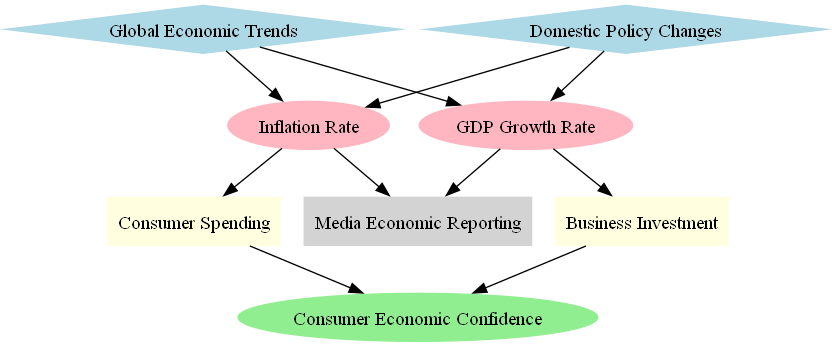

In [15]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [16]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
# print(FileTemplate('structure').fill_in(ctx))
print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

This exploration delves into China's economic performance in 2021, focusing on the interplay between GDP growth, reported at over 6%, and inflation, sitting around 3%. By examining historical data on China's economic indicators, consumer price indexes, and global market trends, we aim to understand how these factors influenced each other and what this means for the average consumer and businesses in China.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their relationships (including using terms like "affects", "confounder"/"confounding", "mediator"/"

In [17]:
#################################################

structure_raw = '''



[
    {"sentence": "In our analysis, we observe that the general mood of the global economy, including aspects like trade and market dynamics, has a direct influence on both the GDP growth and the rate of inflation in China.", "involved": ["Global Economic Trends", "GDP Growth Rate", "Inflation Rate"]},
    {"sentence": "Similarly, changes in China's own economic policies are seen to impact these two key economic indicators, suggesting a close tie between national policy decisions and the country's economic performance.", "involved": ["Domestic Policy Changes", "GDP Growth Rate", "Inflation Rate"]},
    {"sentence": "The growth of China's GDP appears to significantly drive business investment decisions, indicating a relationship where higher economic growth encourages more investment by businesses.", "involved": ["GDP Growth Rate", "Business Investment"]},
    {"sentence": "Conversely, the level of inflation seems to play a role in shaping consumer spending habits, with different inflation rates potentially leading to varied spending patterns.", "involved": ["Inflation Rate", "Consumer Spending"]},
    {"sentence": "Both business investments and consumer spending patterns come together to shape the overall confidence of consumers in the economy, reflecting a culmination of various economic factors.", "involved": ["Business Investment", "Consumer Spending", "Consumer Economic Confidence"]},
    {"sentence": "Interestingly, the way economic progress, measured by GDP growth and inflation, is reported in the media seems to be a consequence of these two factors, rather than influencing them.", "involved": ["Media Economic Reporting", "GDP Growth Rate", "Inflation Rate"]}
]



'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [18]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

This exploration delves into China's economic performance in 2021, focusing on the interplay between GDP growth, reported at over 6%, and inflation, sitting around 3%. By examining historical data on China's economic indicators, consumer price indexes, and global market trends, we aim to understand how these factors influenced each other and what this means for the average consumer and businesses in China.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Global Economic Trends" is "Favorable" (rather than "Unfavorable")?
2. what is the probability that "Domestic Policy Changes" is "Favorable" (rather than "Unfavorable")?
3. when "Global Economic Trends" is "Unfavorable" and "Domestic Policy Changes" is "Unfavorable": what is the probability that "GDP Growth Rate" is "Ove

In [19]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''


{
  "1": [0.5, 0.6],
  "2": [0.5, 0.6],
  "3": [0.1, 0.2],
  "4": [0.3, 0.4],
  "5": [0.4, 0.5],
  "6": [0.7, 0.8],
  "7": [0.4, 0.5],
  "8": [0.5, 0.6],
  "9": [0.5, 0.6],
  "10": [0.6, 0.7],
  "11": [0.2, 0.3],
  "12": [0.7, 0.8],
  "13": [0.6, 0.7],
  "14": [0.5, 0.6],
  "15": [0.1, 0.2],
  "16": [0.3, 0.4],
  "17": [0.4, 0.5],
  "18": [0.8, 0.9],
  "19": [0.3, 0.4],
  "20": [0.4, 0.5],
  "21": [0.6, 0.7],
  "22": [0.7, 0.8]
}



'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [20]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

variables = {}
for node in ctx['nodes']:
    if len(node['parents']):
        variables[node['name']] = ConditionalBernoulli([variables[parent] for parent in node['parents']])
    else:
        variables[node['name']] = Bernoulli(0.5)
net = BernoulliNetwork(variables)
def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges), 1) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, conditions=conditions)[outcome].item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(20, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

----------------------------  --------------  ---------------  ----------------------------------------------------------------------------------
GDP Growth Rate               Below 6%        Over 6%          Annual growth rate of China's Gross Domestic Product.
Inflation Rate                Below 3%        Around 3%        Annual rate of inflation in China.
Consumer Economic Confidence  Low Confidence  High Confidence  Confidence of consumers in the economy, influencing spending and saving behaviors.
----------------------------  --------------  ---------------  ----------------------------------------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\anwan\miniconda3\Lib\site-packages\torch\masked\maskedtensor\core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Global Economic Trends' means Overall trends in the global economy, including trade and market dynamics.
'Domestic Policy Changes' means Changes in domestic economic policies in China.
'GDP Growth Rate' means Annual growth rate of China's Gross Domestic Product.
'Inflation Rate' means Annual rate of inflation in China.
'Business Investment' means Investment level by businesses in response to economic conditions.
'Consumer Spending' means Spending level of consumers, reflecting economic confidence and purchasing power.
'Consumer Economic Confidence' means Confidence of consumers in the economy, influencing spending and saving behaviors.
'Media Economic Reporting' means The nature of economic reporting in the media, which can influence public perception.
Treatment Value    Treatment        Outcome Value    Outcome                              ATE    Correlation
-----------------  ---------------  ---------------  ----------------------------  ----------  -------------
Over 6%           

C:\Users\anwan\miniconda3\Lib\site-packages\torch\masked\maskedtensor\core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "
ERROR:dowhy.causal_graph: Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
ERROR:dowhy.causal_graph: Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Treatment                                       ATE    Correlation  Outcome
--------------------------------------------  -----  -------------  --------------------------------------------
Favorable Global Economic Trends               0              0     Favorable Domestic Policy Changes
Favorable Global Economic Trends               0.36           0.14  Over 6% GDP Growth Rate
Favorable Global Economic Trends               0.1           -0.02  Around 3% Inflation Rate
Favorable Global Economic Trends               0.18          -0.01  High Investment Business Investment
Favorable Global Economic Trends              -0.01           0.01  High Spending Consumer Spending
Favorable Global Economic Trends               0.07           0     High Confidence Consumer Economic Confidence
Favorable Global Economic Trends               0.12           0.01  Positive Reporting Media Economic Reporting
Favorable Domestic Policy Changes              0              0     Favorable Global Economic T

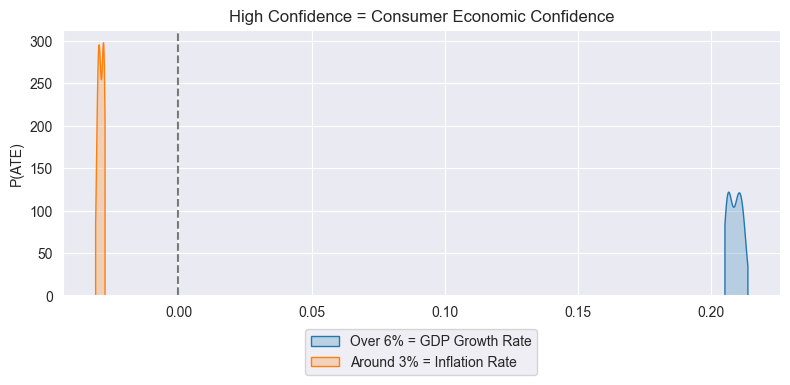

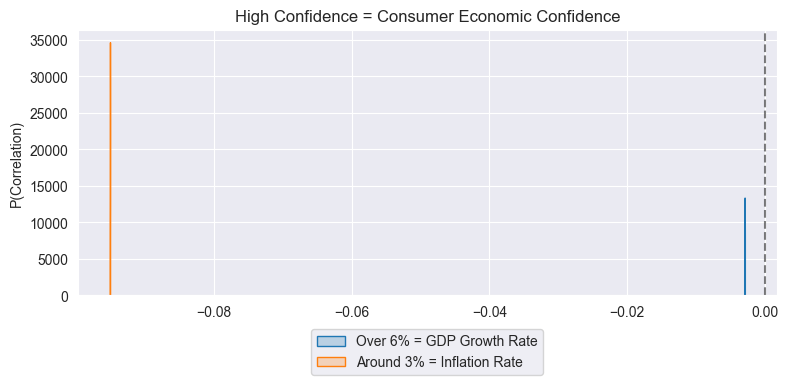

In [22]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'])[node2['name']].item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

print(net.backdoor_estimand(treatment1['name'], outcome['name']))
print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [23]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(FileTemplate('verbs').fill_in(ctx))
# print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Global Economic Trends' (0='Unfavorable', 1='Favorable') means Overall trends in the global economy, including trade and market dynamics.
Variable 'Domestic Policy Changes' (0='Unfavorable', 1='Favorable') means Changes in domestic ec

In [24]:
# verbalization = ctx['verbs']
#################################################
verbalization_raw = '''


{
  "Global Economic Trends": {
    "descriptor": ["the global economic climate", "worldwide trade and market conditions"],
    "subject": "the global economy",
    "predicate0": ["is experiencing downturns", "faces challenges"],
    "predicate1": ["is thriving", "shows positive signs"],
    "pronoun": "it",
    "nounclause0": ["the global economy is in a slump", "there are struggles in worldwide trade and markets"],
    "nounclause1": ["the global economy is booming", "there is a favorable wave in worldwide trade and markets"],
    "preposition": ["amid", "in"],
    "domain": "the global market",
    "subclause0": ["economic trends are on a decline", "market dynamics are unfavorable"],
    "subclause1": ["economic trends are favorable", "market dynamics are thriving"],
    "condition0": ["when global markets struggle", "in times of economic downturn"],
    "condition1": ["when global markets prosper", "during economic upswings"],
    "action0": ["global economic trends decline", "world trade faces challenges"],
    "action1": ["global economic trends improve", "world trade experiences growth"]
  },
  "Domestic Policy Changes": {
    "descriptor": ["the domestic policy landscape", "China's policy environment"],
    "subject": "China's domestic policies",
    "predicate0": ["are undergoing negative changes", "are facing setbacks"],
    "predicate1": ["are improving", "are experiencing positive transformations"],
    "pronoun": "they",
    "nounclause0": ["China's domestic policies are being negatively revised", "there are setbacks in China's policy decisions"],
    "nounclause1": ["China's domestic policies are enhancing", "positive changes are being made in China's policy decisions"],
    "preposition": ["under", "within"],
    "domain": "the policy framework",
    "subclause0": ["policy changes are unfavorable", "reforms are facing resistance"],
    "subclause1": ["policy changes are beneficial", "reforms are being welcomed"],
    "condition0": ["when domestic policies face hurdles", "if policy reforms are setback"],
    "condition1": ["when domestic policies improve", "if policy reforms are successful"],
    "action0": ["domestic policies are negatively changed", "unfavorable policy reforms are enacted"],
    "action1": ["domestic policies are positively revised", "favorable policy reforms are implemented"]
  },
  "GDP Growth Rate": {
    "descriptor": ["the GDP growth pace", "China's economic expansion rate"],
    "subject": "China's GDP growth",
    "predicate0": ["falls short of expectations", "is below the desired threshold"],
    "predicate1": ["surpasses the standard mark", "is robustly climbing"],
    "pronoun": "it",
    "nounclause0": ["China's GDP growth is lagging", "the economic growth rate is not meeting targets"],
    "nounclause1": ["China's GDP growth is exceeding norms", "the economic growth rate is outpacing expectations"],
    "preposition": ["with", "at"],
    "domain": "economic performance",
    "subclause0": ["the growth rate is underwhelming", "economic expansion is slower than anticipated"],
    "subclause1": ["the growth rate is impressive", "economic expansion is rapid"],
    "condition0": ["if the GDP growth is sluggish", "when the economic expansion is slow"],
    "condition1": ["if the GDP growth is high", "when the economic expansion is fast"],
    "action0": ["GDP growth slows down", "economic expansion falls below 6%"],
    "action1": ["GDP growth accelerates", "economic expansion exceeds 6%"]
  },
  "Inflation Rate": {
    "descriptor": ["the inflationary trend", "China's rate of inflation"],
    "subject": "the inflation rate",
    "predicate0": ["remains contained", "is below the average"],
    "predicate1": ["hovers around the standard", "is moderately stable"],
    "pronoun": "it",
    "nounclause0": ["inflation stays below the usual level", "price rises are lower than expected"],
    "nounclause1": ["inflation stabilizes around a normal rate", "price rises are around the average"],
    "preposition": ["at", "within"],
    "domain": "economic indicators",
    "subclause0": ["prices are not increasing rapidly", "there's a lower than usual rise in costs"],
    "subclause1": ["prices are increasing at a regular pace", "there's a moderate rise in costs"],
    "condition0": ["if inflation is lower than usual", "when price rises are minimal"],
    "condition1": ["if inflation is around the average", "when price rises are moderate"],
    "action0": ["inflation falls below 3%", "price rises are contained"],
    "action1": ["inflation stays around 3%", "price rises reach a moderate level"]
  },
  "Business Investment": {
    "descriptor": ["the business investment level", "corporate investment trends"],
    "subject": "businesses",
    "predicate0": ["are cautious with investments", "hold back on spending"],
    "predicate1": ["are ramping up investments", "are investing aggressively"],
    "pronoun": "they",
    "nounclause0": ["businesses are cutting back on investments", "corporate spending is reduced"],
    "nounclause1": ["businesses are increasing their investments", "corporate spending is on the rise"],
    "preposition": ["among", "in"],
    "domain": "the corporate sector",
    "subclause0": ["investment decisions are conservative", "spending habits are restricted"],
    "subclause1": ["investment decisions are bold", "spending habits are expansive"],
    "condition0": ["if businesses are wary of investing", "when corporate spending is limited"],
    "condition1": ["if businesses are confident in investing", "when corporate spending is liberal"],
    "action0": ["companies reduce their investments", "there's a cutback in corporate spending"],
    "action1": ["companies increase their investments", "there's a surge in corporate spending"]
  },
  "Consumer Spending": {
    "descriptor": ["consumer spending habits", "the shopping trends of individuals"],
    "subject": "consumers",
    "predicate0": ["are tightening their belts", "spend less"],
    "predicate1": ["are loosening their purse strings", "spend more"],
    "pronoun": "they",
    "nounclause0": ["consumers are cutting back on expenses", "there's a decrease in personal spending"],
    "nounclause1": ["consumers are increasing their expenses", "there's an upswing in personal spending"],
    "preposition": ["among", "in"],
    "domain": "the retail sector",
    "subclause0": ["spending is conservative", "purchases are reduced"],
    "subclause1": ["spending is liberal", "purchases are increased"],
    "condition0": ["if consumers are saving more", "when personal expenses are cut"],
    "condition1": ["if consumers are spending freely", "when personal expenses rise"],
    "action0": ["people spend less", "there's a decrease in consumer spending"],
    "action1": ["people spend more", "there's an increase in consumer spending"]
  },
  "Consumer Economic Confidence": {
    "descriptor": ["consumer confidence levels", "the public's economic optimism"],
    "subject": "people",
    "predicate0": ["are wary about the economy", "have reservations about spending"],
    "predicate1": ["are confident in the economy", "are optimistic about spending"],
    "pronoun": "they",
    "nounclause0": ["people are skeptical about the economic future", "there's a lack of confidence in spending"],
    "nounclause1": ["people are positive about the economic future", "there's strong confidence in spending"],
    "preposition": ["in", "among"],
    "domain": "consumers",
    "subclause0": ["the outlook is cautious", "economic sentiments are subdued"],
    "subclause1": ["the outlook is positive", "economic sentiments are buoyant"],
    "condition0": ["if there's low economic confidence", "when people are hesitant to spend"],
    "condition1": ["if there's high economic confidence", "when people are eager to spend"],
    "action0": ["consumer confidence dips", "people become more cautious with money"],
    "action1": ["consumer confidence soars", "people become more liberal with spending"]
  },
  "Media Economic Reporting": {
    "descriptor": ["the tone of economic reporting in the media", "the nature of financial news coverage"],
    "subject": "economic reports",
    "predicate0": ["highlight economic challenges", "focus on negative economic aspects"],
    "predicate1": ["emphasize economic strengths", "portray a positive economic outlook"],
    "pronoun": "they",
    "nounclause0": ["economic reports emphasize the challenges", "news coverage focuses on the downsides of the economy"],
    "nounclause1": ["economic reports highlight positive developments", "media coverage is optimistic about the economy"],
    "preposition": ["in", "among"],
    "domain": "media outlets",
    "subclause0": ["the focus is on economic difficulties", "the narrative is centered on financial struggles"],
    "subclause1": ["the emphasis is on economic growth", "the narrative is optimistic about financial prospects"],
    "condition0": ["when the media reports negatively on the economy", "if economic news coverage is pessimistic"],
    "condition1": ["when the media portrays the economy positively", "if financial news coverage is optimistic"],
    "action0": ["the media shifts to negative economic reporting", "news outlets start focusing on economic downturns"],
    "action1": ["the media adopts a positive tone in economic reporting", "news outlets begin highlighting economic successes"]
  }
}



'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)

In [25]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

This exploration delves into China's economic performance in 2021, focusing on the interplay between GDP growth, reported at over 6%, and inflation, sitting around 3%. By examining historical data on China's economic indicators, consumer price indexes, and global market trends, we aim to understand how these factors influenced each other and what this means for the average consumer and businesses in China.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('GDP Growth Rate') > 0
	2. ATE('Inflation Rate') < 0
	3. ATE('GDP Growth Rate') < ATE('Inflation Rate')
	4. |ATE('GDP Growth Rate')| < |ATE('Inflation Rate')|
	5. CATE('GDP Growth Rate' | 'Global Economic Trends' = 0) < 0
	6. CATE('Inflation Rate' | 'Global Economic Trends' = 0) < 0
	7. CATE('GDP Grow

In [26]:
# setting = ctx['questions']
#################################################
settings_raw = '''


{
    "1": {
        "question": "Does a higher GDP growth rate generally lead to better overall economic outcomes?",
        "answer": "yes",
        "explanation": "A higher GDP growth rate typically results in more positive economic outcomes."
    },
    "2": {
        "question": "Is a lower inflation rate generally associated with better economic outcomes?",
        "answer": "yes",
        "explanation": "Lower inflation rates are often linked with more favorable economic outcomes."
    },
    "3": {
        "question": "Does GDP growth have a greater impact on economic outcomes than inflation rates?",
        "answer": "no",
        "explanation": "Inflation rates have a more significant impact on economic outcomes compared to GDP growth."
    },
    "4": {
        "question": "Is the impact of inflation rate fluctuations more significant than changes in GDP growth on economic outcomes?",
        "answer": "yes",
        "explanation": "Fluctuations in the inflation rate have a more substantial effect on economic outcomes than variations in GDP growth."
    },
    "5": {
        "question": "In times of global economic downturn, does GDP growth tend to negatively impact economic outcomes?",
        "answer": "yes",
        "explanation": "During global economic downturns, GDP growth is likely to have a negative effect on economic outcomes."
    },
    "6": {
        "question": "During unfavorable global economic trends, does a higher inflation rate lead to worse economic outcomes?",
        "answer": "yes",
        "explanation": "When global economic trends are unfavorable, an increased inflation rate typically results in poorer economic outcomes."
    },
    "7": {
        "question": "In periods of global economic decline, does inflation rate have a greater negative impact than GDP growth on economic outcomes?",
        "answer": "yes",
        "explanation": "During global economic downturns, the inflation rate has a more pronounced negative effect on economic outcomes compared to GDP growth."
    },
    "8": {
        "question": "Is the impact of GDP growth more significant than that of inflation during unfavorable global economic conditions?",
        "answer": "no",
        "explanation": "During periods of unfavorable global economic conditions, inflation rate has a more significant impact than GDP growth."
    },
    "9": {
        "question": "In times of favorable global economic trends, does GDP growth tend to have a negative impact on economic outcomes?",
        "answer": "no",
        "explanation": "When global economic trends are favorable, GDP growth usually has a positive impact on economic outcomes."
    },
    "10": {
        "question": "During favorable global economic conditions, does a higher inflation rate lead to worse economic outcomes?",
        "answer": "no",
        "explanation": "In periods of favorable global economic trends, an increased inflation rate does not typically result in poorer economic outcomes."
    },
    "11": {
        "question": "In a favorable global economic environment, does inflation rate have a lesser impact than GDP growth on economic outcomes?",
        "answer": "yes",
        "explanation": "Under favorable global economic conditions, GDP growth tends to have a more significant impact on economic outcomes than the inflation rate."
    },
    "12": {
        "question": "Is the impact of inflation rate fluctuations more significant than changes in GDP growth during favorable global economic conditions?",
        "answer": "no",
        "explanation": "During favorable global economic conditions, changes in GDP growth have a more substantial effect on economic outcomes than fluctuations in the inflation rate."
    },
    "13": {
        "question": "Does GDP growth have a greater positive impact on economic outcomes during favorable global trends compared to unfavorable ones?",
        "answer": "yes",
        "explanation": "GDP growth tends to have a more positive effect on economic outcomes during favorable global economic trends than during unfavorable ones."
    },
    "14": {
        "question": "Is the effect of GDP growth on economic outcomes more pronounced during unfavorable global economic conditions?",
        "answer": "no",
        "explanation": "The impact of GDP growth on economic outcomes is less pronounced during unfavorable global economic conditions compared to favorable ones."
    },
    "15": {
        "question": "Does inflation rate impact economic outcomes more negatively in unfavorable global economic conditions than in favorable ones?",
        "answer": "yes",
        "explanation": "Inflation rate tends to have a more negative impact on economic outcomes during unfavorable global economic conditions compared to favorable ones."
    },
    "16": {
        "question": "Is the effect of inflation rate on economic outcomes less pronounced during favorable global conditions?",
        "answer": "yes",
        "explanation": "The impact of the inflation rate on economic outcomes is less significant during favorable global economic conditions."
    },
    "17": {
        "question": "Does maintaining unfavorable domestic policies in China lead to an increase in GDP growth?",
        "answer": "yes",
        "explanation": "Maintaining unfavorable domestic policies in China is associated with an increase in GDP growth."
    },
    "18": {
        "question": "With unfavorable domestic policies in place, does China experience a decrease in inflation?",
        "answer": "no",
        "explanation": "Unfavorable domestic policies do not lead to a decrease in inflation in China."
    },
    "19": {
        "question": "Is the impact of unfavorable domestic policies on GDP growth greater than on inflation?",
        "answer": "yes",
        "explanation": "The influence of unfavorable domestic policies on China's GDP growth is greater than its impact on inflation."
    },
    "20": {
        "question": "Is the absolute impact on inflation rate smaller than that on GDP growth rate under unfavorable domestic policies?",
        "answer": "yes",
        "explanation": "Under unfavorable domestic policies, the absolute impact on China's inflation rate is smaller compared to the impact on GDP growth."
    },
    "21": {
        "question": "Do favorable domestic policies in China lead to a decrease in GDP growth?",
        "answer": "no",
        "explanation": "Favorable domestic policies in China do not result in a decrease in GDP growth."
    },
    "22": {
        "question": "With favorable domestic policies, does China experience an increase in inflation?",
        "answer": "yes",
        "explanation": "Favorable domestic policies in China are associated with an increase in inflation."
    },
    "23": {
        "question": "Is the impact of favorable domestic policies on GDP growth less than on inflation?",
        "answer": "yes",
        "explanation": "The impact of favorable domestic policies on China's GDP growth is less than its impact on inflation."
    },
    "24": {
        "question": "Is the absolute impact on GDP growth rate larger than that on inflation rate under favorable domestic policies?",
        "answer": "no",
        "explanation": "Under favorable domestic policies, the absolute impact on GDP growth in China is not larger than the impact on inflation."
    },
    "25": {
        "question": "Is the impact on GDP growth less when changing from unfavorable to favorable domestic policies?",
        "answer": "no",
        "explanation": "Switching from unfavorable to favorable domestic policies does not result in a lesser impact on China's GDP growth."
    },
    "26": {
        "question": "Is the absolute impact on GDP growth greater when shifting from unfavorable to favorable domestic policies?",
        "answer": "yes",
        "explanation": "The absolute impact on China's GDP growth is greater when shifting from unfavorable to favorable domestic policies."
    },
    "27": {
        "question": "Does the inflation rate increase more under favorable policies compared to unfavorable ones?",
        "answer": "yes",
        "explanation": "The inflation rate in China increases more under favorable domestic policies compared to when the policies are unfavorable."
    },
    "28": {
        "question": "Is the absolute impact on the inflation rate greater with favorable policies compared to unfavorable ones?",
        "answer": "yes",
        "explanation": "The absolute impact on China's inflation rate is greater with favorable domestic policies compared to when the policies are unfavorable."
    }
}




'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [27]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

'China_2021_GDP_and_Inflation_Exploration.json'

In [27]:
ctx['stats'] = {int(k): v for k, v in ctx['stats'].items()}
ctx['verbs'] = {k: {int(k2): v2 for k2, v2 in v.items()} for k, v in ctx['verbs'].items()}
for k, v in ctx['verbs'].items():
    for k2, v2 in v.items():
        if 'value' in v2:
            v2['value'] = {int(k3): v3 for k3, v3 in v2['value'].items()}
ctx['questions']['questions'] = {int(k): v for k, v in ctx['questions']['questions'].items()}

In [28]:
rawverbs = ctx['verbs']
rawvars = {node['name']: node for node in ctx['nodes']}

In [29]:
print(net.backdoor_estimand(treatment1['name'], outcome['name']))
print(net.backdoor_estimand(treatment2['name'], outcome['name']))

('ParticipationAppleAcademy', 'EmploymentRateTech', ['LocalEconCond'])
('UnivIndustryCollab', 'EmploymentRateTech', ['LocalEconCond'])


In [30]:
qkey = random.choice(list(ctx['questions']['questions']))
qkey = 3
qinfo = ctx['questions']['questions'][qkey]
query = ctx['queries'][qkey-1]
print(ctx['query_description'].split('\n')[qkey-1])
print(query)
qinfo

	3. ATE('ParticipationAppleAcademy') < ATE('UnivIndustryCollab')
{'treatment1': 'ParticipationAppleAcademy', 'treatment2': 'UnivIndustryCollab', 'query': 'ate', 'type': 'ate-compare', 'criterion': '<'}


{'question': 'Is participating in the Apple Academy program more influential in increasing tech sector employment than active university-industry collaboration?',
 'answer': 'no',
 'explanation': 'Active university-industry collaboration tends to have a more significant impact on employment in the tech sector compared to individual participation in programs like Apple Academy.',
 'wrong_explanation': 'Participation in the Apple Academy program is more effective in increasing employment in the tech sector compared to university-industry collaboration.'}

In [ ]:
# 1. One of the variables is {variable}.
# 2. We estimate {subject} [often/usually/sometimes/rarely/etc.] {value}.
# 3. There is a [number]% chance that {value}.
# 4. [number]% of {domain} {value}.
# 5. [number]% of the time {value}.
# 6. Conditional sentence: {value}, [some consequence].
# 7. Interventional: If {value}, [some effect].

In [63]:
next(iter(rawverbs.values()))

{1: {'variable': ['the age of the refinery',
   'how long the refinery has been operational']},
 2: {'subject': 'the refinery',
  'value': {0: ['is a new facility', 'has been recently established'],
   1: ['has been operating for many years', 'is an older establishment']}},
 3: {'value': {0: ['the refinery is newly built',
    'the refinery has been recently established'],
   1: ['the refinery is quite old',
    'the refinery has many years of operation']}},
 4: {'domain': 'refineries',
  'value': {0: ['are new establishments', 'have been recently built'],
   1: ['are older facilities', 'have been operating for many years']}},
 5: {'value': {0: ['the refinery is a new establishment',
    'the refinery has been recently constructed'],
   1: ['the refinery is an old establishment',
    'the refinery has been operating for a long time']}},
 6: {'value': {0: ['If the refinery is newly established',
    'In newer refineries'],
   1: ['If the refinery has been around for many years',
    'In

In [ ]:
varverbs = {}

for var, raw in rawverbs.items():
    info = {'values': {0: {}, 1: {}}}
    info0 = info['values'][0]
    info1 = info['values'][1]
    
    info['variable'] = raw[1]['variable']
    info['subject'] = raw[2]['subject']
    info['domain'] = raw[3]['domain']
    
    
    
    for i in [0, 1]:
        info_val = raw[2]['value'][i]
        info_val['verb'] = raw[2]['value'][i]
        

    varverbs[var] = info

In [62]:
rawverbs[treatment1['name']]

{1: {'variable': ['the safety protocols in place at the refinery',
   'how well the refinery follows safety guidelines']},
 2: {'subject': 'the refinery',
  'value': {0: ['lacks adequate safety protocols',
    'has insufficient safety measures'],
   1: ['maintains adequate safety protocols', 'has robust safety measures']}},
 3: {'value': {0: ['safety protocols are inadequate',
    'safety measures are not up to standard'],
   1: ['safety protocols are thoroughly implemented',
    'safety measures are comprehensive']}},
 4: {'domain': 'refineries',
  'value': {0: ['lack adequate safety measures',
    'do not follow safety guidelines properly'],
   1: ['have robust safety protocols',
    'adhere strictly to safety guidelines']}},
 5: {'value': {0: ['safety protocols are not followed properly',
    'safety measures are neglected'],
   1: ['safety protocols are strictly followed',
    'safety measures are taken seriously']}},
 6: {'value': {0: ['If safety protocols are lacking',
    'In re

In [28]:
rawverbs[outcome['name']]

{'1': {'variable': ['public support for the climate bill',
   "the climate bill's popularity"]},
 '2': {'subject': 'the climate bill',
  'value': {'0': ['lacks public support', 'is unpopular among the public'],
   '1': ['enjoys high public support', 'is popular among the public']}},
 '3': {'value': {'0': ['there is little public backing for the climate bill',
    'the climate bill is not popular'],
   '1': ['there is strong public support for the climate bill',
    'the climate bill is popular']}},
 '4': {'domain': 'public opinions',
  'value': {'0': ['do not favor the climate bill',
    'show disapproval of the climate bill'],
   '1': ['favor the climate bill', 'show approval of the climate bill']}},
 '5': {'value': {'0': ['the climate bill struggles to gain public support',
    'the climate bill faces public disapproval'],
   '1': ['the climate bill wins public support',
    'the climate bill is well-received by the public']}},
 '6': {'value': {'0': ['If public support for the climat

In [ ]:
example_tmpl = '{subject} often {value}.'

In [35]:
rawverbs

{'Presidential Engagement in Climate Discussions': {'1': {'variable': ['presidential involvement in climate talks',
    "the president's active participation in climate discussions"]},
  '2': {'subject': 'the president',
   'value': {'0': ['is not involved in climate discussions',
     'does not engage in climate talks'],
    '1': ['actively participates in climate discussions',
     'is deeply involved in climate talks']}},
  '3': {'value': {'0': ['the president is not engaged in climate talks',
     'there is no presidential involvement in climate discussions'],
    '1': ['the president is actively engaged in climate talks',
     'there is direct presidential involvement in climate discussions']}},
  '4': {'domain': 'instances of climate discussions',
   'value': {'0': ['do not include presidential engagement',
     "lack the president's involvement"],
    '1': ['include active presidential participation',
     "feature the president's active involvement"]}},
  '5': {'value': {'0': [

In [80]:
prompt = FileTemplate('motivation').fill_in(ctx)
print(prompt)

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Inside the race to keep secrets safe from the quantum computing revolution - Telegraph.co.uk
Description: Start-ups are taking part in a global competition to upgrade encryption to fend off the quantum computing threat
Original Language: English
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You do not need to write the entire analysis, just the introduction. Avoid using any technical jargon (such as words like "statistical analysis" or "mode

In [77]:
{
  "introduction": "With the rise of quantum computing posing a real challenge to current encryption methods, there's a fascinating question about how prepared different tech companies are for this change. By examining the patterns in investments made by these companies into quantum-safe technologies, we can get a sense of who's leading and who might be lagging in this race. This exploration would involve looking at the amount and types of investments over the past few years, delving into the sectors these companies belong to, and assessing their geographical distribution.",
  "title": "Quantum_Leap_In_Encryption_Preparedness"
}


{'introduction': "Imagine we're tracking a high-stakes race where companies around the world are scrambling to make their secrets quantum-proof. We'd gather data on how different start-ups are updating their encryption methods, noting things like the type of technology they're using, their progress speed, and the investments they're receiving. By looking at these pieces, we can understand who's leading in this crucial tech shift and what strategies are proving most effective.",
 'proposed_title': 'QuantumLeap_EncryptionRace'}

In [ ]:

# For example, if the article is about some political decision or issue in the economy, then we can imagine using that article (and some implied associated data) to analyze how some specific company should adjust investments or how some associated economic indicator will change. 


In [ ]:
ctx.include(get_verbalization_info);
verb_prompt_template = '''We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a news paper article or casual conversation, while still being semantically equivalent to the original variable and value.

Here are the templates that we use to verbalize the variables:

1. {{subject}} [often/usually/sometimes/rarely/etc.] {{value}}.
2. There is a [number]% chance that {{value}}.
3. [number]% of {{domain}} {{value}}.
4. [number]% of the time {{value}}.
5. Conditional sentence: {{value}}, [some consequence].
6. Interventional: If {{value}}, [some effect].

{variable_description}

Here are some examples of verbalizations of the variable. For each of the templates fill in the blanks (and include 2-3 examples for each template). Format your response as a python dictionary. For example, a variable "Smoking Rate" which takes the values "Low Smoking Rate" and "High Smoking Rate" can be verbalized like this:

```python
verbalizations = {{
  "Smoking Rate": {{
    "Low Smoking Rate": {{
      1: {{"subject": "people", "value": ["do not smoke", "are non-smokers"]}},
      2: {{"value": ["a person does not smoke", "people are non-smokers"]}}, 
      3: {{"domain": "people", "value": ["do not smoke", "are non-smokers"]}}, 
      4: {{"value": ["people do not smoke", "people are non-smokers"]}},
      5: {{"value": ["For people that do not smoke", "Among non-smokers"]}}, 
      6: {{"value": ["the smoking rate is decreased", "people stop smoking"]}},
    }},
    "High Smoking Rate": {{
      ...
    }}
  }},
  ...
}}
```

Answer concisely and precisely in the desired format, and only replace the blanks in curly braces. Do not add any additional comments or discussion. Most importantly, the verbalizations should not contain quantitative information like "often" or "rarely", and instead always assert the corresponding value.'''

tmpl = FixedTemplate('verb_prompt', verb_prompt_template)
ctx.include(tmpl,);
print(ctx['verb_prompt'])

In [29]:
# # ate1_template = '{ate1:.3f} = ATE({{treatments}[0]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][0]!r}))'
# # ate2_template = '{ate2:.3f} = ATE({{treatments}[1]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][0]!r}))'
# ate_tmpl = '{val:.3f} = ATE({treatment!r}) = E({outcome!r} | do({treatment!r}=1)) - E({outcome!r} | do({treatment!r}=0))'
# cate_tmpl = ('{val:.3f} = CATE({treatment!r} | {confounder!r}={cval}) = '
#              'E[{outcome!r} | {confounder!r}={cval}, do({treatment!r}=1)] - E[{outcome!r} | {confounder!r}={cval}, do({treatment!r}=0)]')
# for treatment, ate in [(treatment1, ate1.mean().item()), (treatment2, ate2.mean().item())]:
#     print(SimpleTemplater(ate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, val=ate))
# for (treatment, confounder, cval), cate in zip(*[cate_keys, cates]):
#     print(SimpleTemplater(cate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, confounder=confounder, cval=cval, val=cate.mean().item()))

In [44]:
#######################################################################

setting = {
    "introduction": "In light of the new decree by Prime Minister Giuseppe Conte, introducing a curfew in regions like Lombardy and Piedmont, it's crucial to understand how such decisions affect public health and behavior. This understanding can help in assessing the effectiveness of such measures and their impact on society.",
    "overview": "Our approach looks at how different factors like the curfew enforcement, public response, and healthcare capacity interplay with each other. It's like a web, where pulling one strand can cause movement in another, and we try to understand these relationships, like how public compliance might be influenced by the curfew or how all these affect public health.",
    "questions": {
        1: {"question": "Does implementing a curfew generally lead to better public health outcomes?", "answer": "yes", "explanation": "Implementing a curfew is likely to have a positive effect on public health by controlling the situation that necessitated the curfew.", "wrong_explanation": "Implementing a curfew might not significantly impact public health, as other factors could play a more dominant role."},
        2: {"question": "Is public non-compliance with a curfew typically associated with better public health outcomes?", "answer": "no", "explanation": "Public non-compliance with a curfew is generally not expected to contribute positively to public health outcomes.", "wrong_explanation": "Public non-compliance might actually lead to better public health outcomes as it indicates normalcy and lesser public panic."},
        3: {"question": "Is the positive impact on public health greater when a curfew is implemented than when the public complies with it?", "answer": "yes", "explanation": "The direct enforcement of a curfew is likely to have a stronger positive impact on public health than the variable level of public compliance.", "wrong_explanation": "Public compliance with the curfew could have a greater positive impact on public health than the mere implementation of the curfew."},
        4: {"question": "Do both the implementation of a curfew and the lack of public compliance have a combined negative effect on public health?", "answer": "no", "explanation": "While the lack of public compliance might negatively affect public health, the implementation of a curfew is expected to have a positive impact, which does not result in a combined negative effect.", "wrong_explanation": "The negative impacts of both non-compliance and curfew implementation may combine to deteriorate public health."},
        5: {"question": "In regions with high healthcare capacity, does implementing a curfew have a positive impact on public health?", "answer": "yes", "explanation": "In areas with strong healthcare systems, the implementation of a curfew is likely to further bolster public health outcomes.", "wrong_explanation": "Even in regions with high healthcare capacity, a curfew might not significantly improve public health outcomes."},
        6: {"question": "In regions with low healthcare capacity, does implementing a curfew have a positive impact on public health?", "answer": "yes", "explanation": "In regions where healthcare resources are limited, implementing a curfew can be crucial in preventing the overburdening of the healthcare system.", "wrong_explanation": "A curfew might not be as effective in regions with low healthcare capacity due to the already strained resources."},
        7: {"question": "In regions with high healthcare capacity, does high public compliance with the curfew lead to worse public health outcomes?", "answer": "no", "explanation": "In areas with ample healthcare resources, high public compliance with a curfew is expected to support or maintain good public health outcomes.", "wrong_explanation": "High compliance in regions with strong healthcare systems might lead to negative public health outcomes due to over-cautious behavior."},
        8: {"question": "In regions with low healthcare capacity, does high public compliance with the curfew lead to better public health outcomes?", "answer": "yes", "explanation": "In areas with limited healthcare resources, high compliance with curfew measures can play a critical role in maintaining or improving public health outcomes.", "wrong_explanation": "High public compliance in regions with low healthcare capacity might not significantly improve public health outcomes."},
        9: {"question": "Is the positive impact on public health of implementing a curfew greater in regions with low healthcare capacity compared to those with high capacity?", "answer": "no", "explanation": "The positive impact of a curfew is likely significant in both scenarios but not necessarily greater in regions with lower healthcare capacity.", "wrong_explanation": "Implementing a curfew in regions with low healthcare capacity might have a greater positive impact on public health compared to regions with high healthcare capacity."},
        10: {"question": "Does high public compliance with the curfew lead to better public health outcomes in regions with high healthcare capacity compared to those with low capacity?", "answer": "yes", "explanation": "High compliance in regions with strong healthcare infrastructure likely results in more pronounced improvements in public health compared to regions with weaker healthcare systems.", "wrong_explanation": "The impact of high public compliance on public health might be greater in regions with low healthcare capacity."},
        11: {"question": "Is the positive impact on public health from implementing a curfew less in regions with high healthcare capacity than the impact of high public compliance in these regions?", "answer": "no", "explanation": "The implementation of a curfew is likely to have a significant positive impact on public health, potentially more so than the variable of public compliance, even in regions with high healthcare capacity.", "wrong_explanation": "In regions with high healthcare capacity, the impact of public compliance might be more significant for public health than the implementation of a curfew."},
        12: {"question": "Is the positive impact on public health from implementing a curfew less in regions with low healthcare capacity than the impact of high public compliance in these regions?", "answer": "yes", "explanation": "In regions with low healthcare capacity, the impact of high public compliance might be more crucial for public health than the mere implementation of a curfew.", "wrong_explanation": "Implementing a curfew in regions with low healthcare capacity is likely to have a greater positive impact on public health than high public compliance."}
    },
}



#######################################################################
ctx['setting'] = setting

# Save Story

In [59]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from rake_nltk import Rake
import spacy
import random

In [61]:
example_texts = [val for var in raw_verbalization.values() for varval in var.values() for val in varval[4]['value']]
len(example_texts)

In [53]:
stop_words = set(stopwords.words('english'))
stop_words.update("'s", '|', 'I', "n't", "`s", "'s", 'n`t')

nlp = spacy.load('en_core_web_md')



In [79]:
text = "Covid-19 mortality rate is high"
text = random.choice(example_texts)
print(text)
doc = nlp(text)
subject, verb = None, None
for token in doc:
    if "subj" in token.dep_:
        subject = token.text
    # if "VERB" in token.pos_:
    #     verb = token.text
print(subject, verb)
noun_phrases = [chunk.text for chunk in doc.noun_chunks]
print(noun_phrases)

there is widespread healthcare availability in Moscow
None None
['widespread healthcare availability', 'Moscow']


In [21]:
old_prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence. For each set of questions, fill in the blank and then for each possible descriptor of the probability, provide a reasonable quantitative estimate for the lower and upper bounds of the probability that would be implied by that evidence if the variable took on the value corresponding to 1. Note that your estimates for each descriptor should conform to common sense and reflect the meaning of the variable taking on the value corresponding to 1.

For example, if the question is:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: ['low', 'high', 'very high']

1. "Tax Rate" can either be 0="Decreased" or 1="Increased".
2. "Vaccination Status" can either be 0="Not Vaccinated" or 1="Vaccinated".
...

You should answer in the following format:

```python
evidence = {{
  1: {{'blank': {{'Decreased': 'decreased taxes', 'Increased': 'increased taxes'}} 'implications': {{'low': [0.2, 0.4], 'high': [0.6, 0.8], 'very high': [0.8, 0.9]}}}},
  2: {{'blank': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}} 'implications': {{'low': [0.3, 0.5], 'high': [0.7, 0.9], 'very high': [0.85, 0.99]}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence using a few templates. For each template and variable, fill in the blank and then for each possible value the variable can take. Always use the present tense and make sure to use simple but precise language so the evidence can be communicated clearly. Also, only fill in the templates that make sense for the variable values.

For example, if the question is:

Template A: "The probability of {variable} is high."
Template B: "{variable} often."
Template C: "It is likely that {variable}."
Template D: "Few {subject} {variable}."

1. "Tax Rate": ["Decreased", "Increased"]
2. "Vaccination Status": ["Not Vaccinated", "Vaccinated"]
...

You should answer in the following format:

```python
evidence = {{
  1: {{'A': {{'variable': ['decreased taxes', 'increased taxes']}},
       'B': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'C': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'D': {{'subject': [], 'variable': ['taxes are decreased', 'taxes are increased']}}}},
  }},
  2: {{'variable': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

q_template = '{i}. "{variable}" can either be 0="{value}" or 1="{othervalue}".'

verbs = [
    'very low', 'low', 'moderate', 'high', 'very high',
    # 'extremely small', 'small', 'large', 'extremely large',
    'significant', 'negligible', 'substantial', 'insignificant', 'considerable',
    # 'improbable', 'likely', 'probable', 'unlikely', 'certain',
]

In [22]:
nodes = ctx['nodes']
qlines = []
i = 1
for node in nodes:
    v0, v1 = node['values']
    qlines.append(q_template.format(i=i, variable=node['name'], value=v1, othervalue=v0))
    i += 1
questions = '\n'.join(qlines)

In [23]:
tmpl = SimpleTemplater(prompt_template)
tmpl.keys

{'descriptions', 'descriptor', 'descriptors', 'questions', 'spark'}

In [24]:
# print(tmpl.fill_in(dict(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions)))
print(prompt_template.format(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions))

We have a causal bayes net based on the following article:

```
Title: ARM takeover: Qualcomm interested in participating - heise online
Description: If nothing comes of Nvidia's $40 billion ARM takeover, a consortium of several manufacturers could act as investors.
Original Language: German
```

And, for additional context, here are the variables and their descriptions:

"Qualcomm_Participation" means "Participation of Qualcomm in ARM takeover"
"Regulatory_Approval" means "Regulatory approval for ARM takeover"
"Global_Economic_Conditions" means "Current global economic conditions"
"Nvidia_Takeover_Success" means "Success of Nvidia's ARM takeover attempt"
"Investment_Strategy" means "Investment strategy adopted by Qualcomm"
"Tech_Innovation" means "Level of technological innovation in the market"
"Market_Competition" means "Level of market competition in the tech industry"
"Stock_Market_Response" means "Stock market response to the takeover and market conditions"

Now we would like to 

In [ ]:
line_template = 'The probability that __ is {quantity}'

In [120]:
evidence = {
  1: {
    'blank': {'Stimulative': 'stimulative government economic policies', 'Restrictive': 'restrictive government economic policies'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  2: {
    'blank': {'Increase': 'an increase in industrial production', 'Decrease': 'a decrease in industrial production'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  3: {
    'blank': {'Decrease': 'a decrease in the unemployment rate', 'Increase': 'an increase in the unemployment rate'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  4: {
    'blank': {'High': 'high consumer confidence', 'Low': 'low consumer confidence'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  5: {
    'blank': {'Positive Growth': 'positive economic growth', 'No Growth': 'no economic growth'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  6: {
    'blank': {'Good': 'good market performance', 'Poor': 'poor market performance'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  }
}

all(e1['implications'] == e2['implications'] for e1, e2 in combinations(evidence.values(), 2))


True

In [121]:
print(ctx['spark'])

Title: China's economy grows 4.9% while the rest of the world is crippled by coronavirus - Daily Mail
Description: China's economy has grown 4.9 percent in the third quarter from last year proving the country is back to its pre-pandemic trajectory as industrial production is up and unemployment is down.
Original Language: English


In [ ]:
setting = {
    "introduction": "In light of China's notable economic growth of 4.9% amidst the global coronavirus pandemic, as reported by the Daily Mail, this causal model seeks to unravel the underlying factors contributing to this growth. It aims to provide insights into how different aspects such as industrial production and unemployment rates have played a role in shaping China's economic trajectory during this period.",
    "overview": "Our causal graph is a simplified representation of the complex interplay between various economic factors. It includes variables like government policies, industrial production, and unemployment rates, each affecting the other in unique ways. For instance, government policies can be a confounder, affecting both unemployment and industrial production, while consumer confidence acts as a mediator, reflecting the impact of industrial changes on the overall economic growth.",
    "questions": {
        1: {"question": "Does an increase in industrial production have a positive effect on China's economic growth?", "answer": "yes", "explanation": "Given the economic context, an increase in industrial production likely contributes positively to economic growth.", "inequality": "ATE(IP) > 0"},
        2: {"question": "Is the positive impact of decreasing unemployment on economic growth greater than that of increasing industrial production?", "answer": "no", "explanation": "Industrial production typically has a more direct and significant impact on economic growth compared to changes in unemployment rates.", "inequality": "ATE(UR) > ATE(IP)"},
        3: {"question": "Does a decrease in the unemployment rate positively influence China's economic growth?", "answer": "yes", "explanation": "Lower unemployment generally leads to higher consumer spending and economic growth.", "inequality": "ATE(UR) > 0"},
        4: {"question": "Is the impact of industrial production on economic growth stronger than the influence of government economic policies?", "answer": "yes", "explanation": "While government policies set the stage, industrial production is a more direct driver of economic growth.", "inequality": "ATE(IP) > ATE(GEP)"},
        5: {"question": "Does a stimulative government policy have a greater positive effect on economic growth than an increase in industrial production?", "answer": "no", "explanation": "Industrial production, being a direct economic activity, likely has a stronger immediate impact on economic growth than general government policies.", "inequality": "ATE(GEP) > ATE(IP)"}
    },
}


In [227]:
import pandas as pd
from dowhy import CausalModel
from networkx.drawing.nx_pydot import write_dot

In [226]:
G = nx.DiGraph()
for var in net.vars:
    G.add_node(var.name)
    for parent in var.parents:
        G.add_edge(parent.name, var.name)
G

In [127]:
def convert_to_dot(nodes):
    # Start the DOT graph definition
    dot_graph = "digraph {\n"

    # Iterate over nodes to add them to the graph
    for node in nodes:
        dot_graph += f'    "{node["name"]}" [label="{node["name"]}: {node["description"]}"];\n'

        # Add edges from parents to this node
        for parent in node.get("parents", []):
            dot_graph += f'    "{parent}" -> "{node["name"]}";\n'

    dot_graph += "}\n"
    return dot_graph

In [ ]:
net

In [129]:
print(ctx['descriptions'])

"GEP" means "Government Economic Policies"
"IP" means "Industrial Production"
"UR" means "Unemployment Rate"
"CC" means "Consumer Confidence"
"EG" means "Economic Growth"
"MP" means "Market Performance"


In [221]:
# Create a dummy DataFrame
# The columns should match the nodes in your causal graph
dummy_data = pd.DataFrame({
    'EG': [0],   # Economic Growth
    'IP': [0],   # Industrial Production
    'UR': [0],   # Unemployment Rate
    'GEP': [0],  # Government Economic Policies
    'CC': [0],   # Consumer Confidence
    'MP': [0]    # Market Performance
})

# Define your DOT graph (use the function from the previous response)
dot_graph = convert_to_dot(nodes)

# Instantiate the CausalModel with dummy data
model = CausalModel(
    data=dummy_data,
    treatment='CC',  # Replace with your treatment variable name
    outcome='EG',      # Replace with your outcome variable name
    graph=dot_graph
)

identified_estimand = model.identify_effect()
print(identified_estimand)

from sympy import pretty

# # Assuming 'identified_estimand' is the object returned by model.identify_effect()
# 
# # Print the basic information about the estimand
# print("Estimand Identifier:", identified_estimand.identifier)
# print("Estimand Type:", identified_estimand.estimand_type)
# 
# # Accessing the estimands attribute
# estimands_info = identified_estimand.estimands
# 
# # Displaying the estimands information
# print("Estimands Information:")
# print(estimands_info)

identified_estimand.backdoor_variables, identified_estimand.default_backdoor_id

ERROR:dowhy.causal_graph: Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[EG|UR,IP])
d[CC]             
Estimand assumption 1, Unconfoundedness: If U→{CC} and U→EG then P(EG|CC,UR,IP,U) = P(EG|CC,UR,IP)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


({'backdoor1': ['UR', 'IP', 'GEP'],
  'backdoor2': ['UR', 'IP'],
  'backdoor': ['UR', 'IP']},
 'backdoor2')

In [222]:
sym = identified_estimand.estimands[identified_estimand.default_backdoor_id]['estimand']
sym

  d               
─────(E[EG|UR,IP])
d[CC]             

In [223]:
print(pretty(sym))

  d               
─────(E[EG|UR,IP])
d[CC]             


In [224]:
do = sym.args[1][0].args[0][0].name
exp = sym.args[0].args[0].name
if '|' in exp:
    outcome, cond = exp.split('|')
    cond = cond.split(',')
else:
    outcome = exp
    cond = []
    
print(outcome, do, cond)

EG CC ['UR', 'IP']


In [229]:
dummyvars = 'uvwxyz'
assert len(cond) <= len(dummyvars)
psum = ''
condsuffix = ''
if len(cond):
    psum = ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))
    psum = f'E_{{{psum}}} '

    condsuffix = ',' + ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))

expr = f'{psum}{"[ " if len(cond) else ""}p({outcome}=1 | {do}=1{condsuffix}) - p({outcome}=1 | {do}=0{condsuffix}){" ]" if len(cond) else ""}'

# expr = (f'{psum}{" [ " if len(cond) else ""}p({outcome} | {do}=1{", " + ", ".join(cond) if len(cond) else ""}) - p({outcome} | {do}=0{", " + ",".join(cond) if len(cond) else ""}){" ]" if len(cond) else ""}')
print(f'ATE({do} -> {outcome}) = {expr}')

ATE(CC -> EG) = E_{UR=u,IP=v} [ p(EG=1 | CC=1,UR=u,IP=v) - p(EG=1 | CC=0,UR=u,IP=v) ]


In [153]:
sym.variables[0]

AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'name'

In [154]:
expr = sym.expr
expr

In [159]:
e = expr.args[0]

In [160]:
terms = sym.as_terms()
terms

⎛⎡⎛  d               ⎛                ⎛  d              ⎞⎞⎞⎤    ⎞
⎜⎢⎜─────(E[EG|GEP]), ⎜(1.0, 0.0), (), ⎜─────(E[EG|GEP]),⎟⎟⎟⎥, []⎟
⎝⎣⎝d[UR]             ⎝                ⎝d[UR]            ⎠⎠⎠⎦    ⎠

In [161]:
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(Expectation(EG|GEP), [UR])
Coefficient: ((1.0, 0.0), (), (Derivative(Expectation(EG|GEP), [UR]),))


In [164]:
from sympy import symbols, Derivative, Function

# Define your symbols
EG, GEP, UR = symbols('EG GEP UR')

# Define the expected value function
E = Function('E')(EG, GEP)

# Define the derivative
deriv = Derivative(E, UR)

# Extract terms from the derivative
terms = deriv.as_terms()

# Process the terms to extract variable names and relationships
# terms is a tuple, where the first element contains the terms
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(E(EG, GEP), UR)
Coefficient: ((1.0, 0.0), (1,), ())


In [167]:
deriv

In [166]:
E.args